# Premier Lague Current Season Prediction Python Script

## Overview
In this Jupyter notebook, we'll explore and implement a Python script for football predictions. Using historical match data, we'll leverage machine learning algorithms to analyze team performance, player statistics, and other relevant features. The goal is to build a predictive model that can forecast match outcomes and potentially enhance our understanding of key factors influencing football results.

## Key Steps

### 1. Data Acquisition and Exploration
   - Gather historical football match data from reliable sources.
   - Explore the dataset to understand its structure and variables.

### 2. Data Preprocessing
   - Clean and preprocess the data by handling missing values and outliers.
   - Engineer relevant features that may contribute to the predictive model.

### 3. Exploratory Data Analysis (EDA)
   - Conduct exploratory analysis to uncover patterns and insights in the dataset.
   - Visualize team performance, home/away statistics, and trends over time.

### 4. Feature Selection
   - Identify and select key features that have a significant impact on match outcomes.

### 5. Model Development
   - Implement machine learning models such as logistic regression, decision trees, or ensemble methods.
   - Train the model on historical data to learn patterns and relationships.

### 6. Model Evaluation
   - Assess the model's performance using metrics like accuracy, precision, and recall.
   - Validate the model using cross-validation techniques to ensure robustness.

### 7. Prediction and Results
   - Apply the trained model to predict outcomes for upcoming football matches.
   - Evaluate the predictions against actual results to meical data and statistical analysis.


## Imports

In [29]:
from pydantic_settings import BaseSettings

# Data Acquisition and Exploration
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Exploratory Data Analysis (EDA) and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# Model Development
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#import tensorflow as tf
from torch import nn, optim

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Additional Tools
import numpy as np

## Overview of the datasets

All data will be downloaded from the Fantasty Premier League API (https://fantasy.premierleague.com/api/).  A vast number of data elements can be obtained from this API, but we will be focusing on the Team Names, Home Goals, Away Goals and Kickoff Times from the bootstrap-static and fixtures endpoints.

## Data Acquisition and Exploration

### Fixtures Data

Initially we need to get the data from the fixtures API

In [40]:
url_fixtures = "https://fantasy.premierleague.com/api/fixtures"

# Make the GET request for teams and fixtures
response_fixtures = requests.get(url_fixtures)

In [42]:
# Check if the request for fixtures was successful (status code 200)
if response_fixtures.status_code == 200:
    
    # Parse the JSON data from the fixtures response
    fixtures_data = response_fixtures.json()

else:
        # If the request for fixtures was not successful, print the status code
        print(f"Failed to retrieve fixtures data. Status code: {response_fixtures.status_code}")

Now lets view the Fixtures JSON response from the api

In [51]:
# Print the fixtures data response
print(fixtures_data)

[{'code': 2367698, 'event': None, 'finished': False, 'finished_provisional': False, 'id': 162, 'kickoff_time': None, 'minutes': 0, 'provisional_start_time': True, 'started': None, 'team_a': 12, 'team_a_score': None, 'team_h': 3, 'team_h_score': None, 'stats': [], 'team_h_difficulty': 2, 'team_a_difficulty': 2, 'pulse_id': 93482}, {'code': 2367538, 'event': 1, 'finished': True, 'finished_provisional': True, 'id': 1, 'kickoff_time': '2023-08-11T19:00:00Z', 'minutes': 90, 'provisional_start_time': False, 'started': True, 'team_a': 13, 'team_a_score': 3, 'team_h': 6, 'team_h_score': 0, 'stats': [{'identifier': 'goals_scored', 'a': [{'value': 2, 'element': 355}, {'value': 1, 'element': 365}], 'h': []}, {'identifier': 'assists', 'a': [{'value': 1, 'element': 343}, {'value': 1, 'element': 365}], 'h': []}, {'identifier': 'own_goals', 'a': [], 'h': []}, {'identifier': 'penalties_saved', 'a': [], 'h': []}, {'identifier': 'penalties_missed', 'a': [], 'h': []}, {'identifier': 'yellow_cards', 'a': 

Now lets explore the names of the keys from the fixtures data. The fixtures data appears to be a nested json, given that it starts and ends with a "[".  For the purposes of this project, it looks like only the top level keys are releavant, so lets explore them.

In [69]:
# Print the top level keys from the fixtures json
print(fixtures_data[0].keys())

dict_keys(['code', 'event', 'finished', 'finished_provisional', 'id', 'kickoff_time', 'minutes', 'provisional_start_time', 'started', 'team_a', 'team_a_score', 'team_h', 'team_h_score', 'stats', 'team_h_difficulty', 'team_a_difficulty', 'pulse_id'])


Now lets add the data to a dataframe and futher explore the data

In [201]:
# Convert to DataFrame
fixtures_df = pd.DataFrame(fixtures_data)

In [131]:
# Display datatypes in the DataFrame
fixtures_df.dtypes

code                        int64
event                     float64
finished                     bool
finished_provisional         bool
id                          int64
kickoff_time               object
minutes                     int64
provisional_start_time       bool
started                    object
team_a                      int64
team_a_score              float64
team_h                      int64
team_h_score              float64
stats                      object
team_h_difficulty           int64
team_a_difficulty           int64
pulse_id                    int64
dtype: object

In [129]:
# Display basic information about the DataFrame
display(fixtures_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   code                    380 non-null    int64  
 1   event                   379 non-null    float64
 2   finished                380 non-null    bool   
 3   finished_provisional    380 non-null    bool   
 4   id                      380 non-null    int64  
 5   kickoff_time            379 non-null    object 
 6   minutes                 380 non-null    int64  
 7   provisional_start_time  380 non-null    bool   
 8   started                 379 non-null    object 
 9   team_a                  380 non-null    int64  
 10  team_a_score            203 non-null    float64
 11  team_h                  380 non-null    int64  
 12  team_h_score            203 non-null    float64
 13  stats                   380 non-null    object 
 14  team_h_difficulty       380 non-null    in

None

In [128]:
# Display summary statistics
display(fixtures_df.describe())

,code,event,id,minutes,team_a,team_a_score,team_h,team_h_score,team_h_difficulty,team_a_difficulty,pulse_id
count,3.800000e+02,379.000000,380.000000,380.000000,380.000000,203.000000,380.000000,203.000000,380.000000,380.000000,380.000000
mean,2.367728e+06,19.538259,190.500000,48.078947,10.500000,1.364532,10.500000,1.729064,2.700000,2.950000,93510.500000
std,1.098408e+02,10.979321,109.840794,44.953733,5.773884,1.192021,5.773884,1.331452,0.843726,1.024824,109.840794
min,2.367538e+06,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,2.000000,93321.000000
25%,2.367633e+06,10.000000,95.750000,0.000000,5.750000,1.000000,5.750000,1.000000,2.000000,2.000000,93415.750000
50%,2.367728e+06,20.000000,190.500000,90.000000,10.500000,1.000000,10.500000,2.000000,2.500000,3.000000,93510.500000
75%,2.367822e+06,29.000000,285.250000,90.000000,15.250000,2.000000,15.250000,3.000000,3.000000,4.000000,93605.250000
max,2.367917e+06,38.000000,380.000000,90.000000,20.000000,8.000000,20.000000,6.000000,5.000000,5.000000,93700.000000


In [127]:
# Display the first few rows
display(fixtures_df.head())

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id
0,2367698,NaN,False,False,162,None,0,True,None,12,NaN,3,NaN,[],2,2,93482
1,2367538,1.0,True,True,1,2023-08-11T19:00:00Z,90,False,True,13,3.0,6,0.0,"[{'identifier': 'goals_scored', 'a': [{'value'...",5,2,93321
2,2367540,1.0,True,True,2,2023-08-12T12:00:00Z,90,False,True,16,1.0,1,2.0,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,4,93322
3,2367539,1.0,True,True,3,2023-08-12T14:00:00Z,90,False,True,19,1.0,3,1.0,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,2,93323
4,2367541,1.0,True,True,4,2023-08-12T14:00:00Z,90,False,True,12,1.0,5,4.0,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,3,93324


The stats column appears to be another nested set of data, so lets remove that from the datarame to leave us with non nested data only

In [202]:
# Drop stats column from fixtures_df
fixtures_df.drop(['stats'], axis=1, inplace=True)

### Teams Data

The Fixtures Team_H and Team_A values are integers, indicating they are an ID of a team.  Ideally, we want to see the actuall team names, so lets get the data from the teams API

In [ ]:
url_teams = "https://fantasy.premierleague.com/api/bootstrap-static"

# Make the GET request for teams and fixtures
response_teams = requests.get(url_teams)

In [ ]:
# Check if the request for teams was successful (status code 200)
if response_teams.status_code == 200:
    
    # Parse the JSON data from the teams response
    teams_data = response_teams.json()

else:
    # If the request for teams was not successful, print the status code
    print(f"Failed to retrieve teams data. Status code: {response_teams.status_code}")

Now lets view the Teams JSON response from the api

In [49]:
# Print the teams response
print(teams_data)

{'events': [{'id': 1, 'name': 'Gameweek 1', 'deadline_time': '2023-08-11T17:30:00Z', 'average_entry_score': 64, 'finished': True, 'data_checked': True, 'highest_scoring_entry': 3383750, 'deadline_time_epoch': 1691775000, 'deadline_time_game_offset': 0, 'highest_score': 127, 'is_previous': False, 'is_current': False, 'is_next': False, 'cup_leagues_created': False, 'h2h_ko_matches_created': False, 'ranked_count': 0, 'chip_plays': [{'chip_name': 'bboost', 'num_played': 163222}, {'chip_name': '3xc', 'num_played': 287198}], 'most_selected': 355, 'most_transferred_in': 1, 'top_element': 395, 'top_element_info': {'id': 395, 'points': 14}, 'transfers_made': 0, 'most_captained': 355, 'most_vice_captained': 19}, {'id': 2, 'name': 'Gameweek 2', 'deadline_time': '2023-08-18T17:15:00Z', 'average_entry_score': 44, 'finished': True, 'data_checked': True, 'highest_scoring_entry': 3338487, 'deadline_time_epoch': 1692378900, 'deadline_time_game_offset': 0, 'highest_score': 120, 'is_previous': False, 'is

Now lets explore the names of the keys from the teams data. The teams data appears to be an unested json, given that it doesn't start or end with a "[".

In [80]:
# Print the top level keys from the teams json
print(teams_data.keys())

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])


In [96]:
# Print all the keys from within the teams key.
print(list(teams_data['teams'][0].keys()))

['code', 'draw', 'form', 'id', 'loss', 'name', 'played', 'points', 'position', 'short_name', 'strength', 'team_division', 'unavailable', 'win', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away', 'pulse_id']


Now lets add the teams data to a dataframe and futher explore the data

In [145]:
# Convert Teams Data to a list containing a list of team dictionaries
teams_list = teams_data['teams']

# Create an empty DataFrame
teams_df = pd.DataFrame(teams_list)

In [146]:
# Display datatypes in the DataFrame
teams_df.dtypes

code                      int64
draw                      int64
form                     object
id                        int64
loss                      int64
name                     object
played                    int64
points                    int64
position                  int64
short_name               object
strength                  int64
team_division            object
unavailable                bool
win                       int64
strength_overall_home     int64
strength_overall_away     int64
strength_attack_home      int64
strength_attack_away      int64
strength_defence_home     int64
strength_defence_away     int64
pulse_id                  int64
dtype: object

In [147]:
# Display basic information about the DataFrame
display(teams_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   code                   20 non-null     int64 
 1   draw                   20 non-null     int64 
 2   form                   0 non-null      object
 3   id                     20 non-null     int64 
 4   loss                   20 non-null     int64 
 5   name                   20 non-null     object
 6   played                 20 non-null     int64 
 7   points                 20 non-null     int64 
 8   position               20 non-null     int64 
 9   short_name             20 non-null     object
 10  strength               20 non-null     int64 
 11  team_division          0 non-null      object
 12  unavailable            20 non-null     bool  
 13  win                    20 non-null     int64 
 14  strength_overall_home  20 non-null     int64 
 15  strength_overall_away  20

None

In [148]:
# Display summary statistics
display(teams_df.describe())

,code,draw,id,loss,played,points,position,strength,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
count,20.000000,20.0,20.00000,20.0,20.0,20.0,20.0,20.00000,20.0,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,36.050000,0.0,10.50000,0.0,0.0,0.0,0.0,3.15000,0.0,1126.00000,1168.250000,1116.000000,1168.500000,1131.500000,1176.750000,41.050000
std,33.868904,0.0,5.91608,0.0,0.0,0.0,0.0,0.67082,0.0,69.36934,91.122748,69.160378,86.162331,72.640064,94.008328,51.360926
min,1.000000,0.0,1.00000,0.0,0.0,0.0,0.0,2.00000,0.0,1045.00000,1060.000000,1050.000000,1050.000000,1040.000000,1060.000000,1.000000
25%,7.750000,0.0,5.75000,0.0,0.0,0.0,0.0,3.00000,0.0,1095.00000,1100.000000,1077.500000,1120.000000,1080.000000,1107.500000,9.250000
50%,26.000000,0.0,10.50000,0.0,0.0,0.0,0.0,3.00000,0.0,1107.50000,1142.500000,1100.000000,1140.000000,1120.000000,1160.000000,19.500000
75%,50.250000,0.0,15.25000,0.0,0.0,0.0,0.0,3.00000,0.0,1130.00000,1223.750000,1120.000000,1205.000000,1160.000000,1242.500000,39.250000
max,102.000000,0.0,20.00000,0.0,0.0,0.0,0.0,5.00000,0.0,1350.00000,1355.000000,1300.000000,1340.000000,1360.000000,1370.000000,163.000000


In [210]:
# Display the first few rows
display(teams_df.head())

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,None,1,0,Arsenal,0,0,0,ARS,...,None,False,0,1220,1260,1270,1280,1170,1240,1
1,7,0,None,2,0,Aston Villa,0,0,0,AVL,...,None,False,0,1130,1235,1120,1220,1130,1250,2
2,91,0,None,3,0,Bournemouth,0,0,0,BOU,...,None,False,0,1095,1100,1070,1120,1130,1110,127
3,94,0,None,4,0,Brentford,0,0,0,BRE,...,None,False,0,1120,1155,1120,1130,1120,1180,130
4,36,0,None,5,0,Brighton,0,0,0,BHA,...,None,False,0,1130,1185,1100,1120,1160,1250,131


## Data Preprocessing

To get the above 2 sets of data ready for some meaningful analysis,  replace the id values in from the fixtures data set with the corresponding names in the teams data and we only need to look at getting only fixtures that have finished

In [361]:
# Convert to DataFrame
fixtures_df = pd.DataFrame(fixtures_data)
# Drop the Stats data.
fixtures_df.drop(['stats'], axis=1, inplace=True)

In [362]:
display(fixtures_df.head())

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,team_h_difficulty,team_a_difficulty,pulse_id
0,2367698,NaN,False,False,162,None,0,True,None,12,NaN,3,NaN,2,2,93482
1,2367538,1.0,True,True,1,2023-08-11T19:00:00Z,90,False,True,13,3.0,6,0.0,5,2,93321
2,2367540,1.0,True,True,2,2023-08-12T12:00:00Z,90,False,True,16,1.0,1,2.0,2,4,93322
3,2367539,1.0,True,True,3,2023-08-12T14:00:00Z,90,False,True,19,1.0,3,1.0,2,2,93323
4,2367541,1.0,True,True,4,2023-08-12T14:00:00Z,90,False,True,12,1.0,5,4.0,2,3,93324


Now lets add some new relevant features to the dataframe, such as goal difference and winning team

In [363]:
# Select relevant columns from teams_df
home_teams_subset = teams_df[['id', 'strength_overall_home', 
                          'strength_attack_home', 
                          'strength_defence_home']]

away_teams_subset = teams_df[['id', 'strength_overall_away',
                           'strength_attack_away',
                           'strength_defence_away']]

# Merge fixtures_df with teams_subset for Home Team
merged_df = pd.merge(fixtures_df, home_teams_subset, how='left', left_on='team_h', right_on='id')

# Merge fixtures_df with teams_subset for Away Team
merged_df = pd.merge(merged_df, away_teams_subset, how='left', left_on='team_a', right_on='id')

# Replace Team H and Team A values with corresponding names from teams_df
merged_df['team_h'] = merged_df['team_h'].map(teams_df.set_index('id')['name'])
merged_df['team_a'] = merged_df['team_a'].map(teams_df.set_index('id')['name'])


# Drop columns that start with id
columns_to_drop = merged_df.filter(regex='^id').columns
merged_df.drop(columns=columns_to_drop, inplace=True)

# Create new data frame with more meaningful name
fixtures_with_teams_df=merged_df

# Display or use the final dataframe (fixtures_with_teams_df)
display(fixtures_with_teams_df.head())

,code,event,finished,finished_provisional,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,...,team_h_score,team_h_difficulty,team_a_difficulty,pulse_id,strength_overall_home,strength_attack_home,strength_defence_home,strength_overall_away,strength_attack_away,strength_defence_away
0,2367698,NaN,False,False,None,0,True,None,Luton,NaN,...,NaN,2,2,93482,1095,1070,1130,1080,1080,1090
1,2367538,1.0,True,True,2023-08-11T19:00:00Z,90,False,True,Man City,3.0,...,0.0,5,2,93321,1070,1080,1060,1355,1340,1370
2,2367540,1.0,True,True,2023-08-12T12:00:00Z,90,False,True,Nott'm Forest,1.0,...,2.0,2,4,93322,1220,1270,1170,1100,1120,1100
3,2367539,1.0,True,True,2023-08-12T14:00:00Z,90,False,True,West Ham,1.0,...,1.0,2,2,93323,1095,1070,1130,1130,1140,1120
4,2367541,1.0,True,True,2023-08-12T14:00:00Z,90,False,True,Luton,1.0,...,4.0,2,3,93324,1130,1100,1160,1080,1080,1090


#### Match Results

In [364]:
# Total Score
fixtures_with_teams_df['total_score'] = fixtures_with_teams_df['team_h_score'] + fixtures_with_teams_df['team_a_score']

# Score Difference
fixtures_with_teams_df['score_difference'] = fixtures_with_teams_df['team_h_score'] - fixtures_with_teams_df['team_a_score']

# Winning Team (1 if Home Team won, -1 if Away Team won, 0 for draw)
fixtures_with_teams_df['winning_team'] = np.where(fixtures_with_teams_df['team_h_score'] > fixtures_with_teams_df['team_a_score'], 1,
                                      np.where(fixtures_with_teams_df['team_h_score'] < fixtures_with_teams_df['team_a_score'], -1, 0))

# Whether the match ended in a draw
fixtures_with_teams_df['draw'] = fixtures_with_teams_df['team_h_score'] == fixtures_with_teams_df['team_a_score']

#### Team Strength Differences

In [365]:
# Team Overall Strength Difference
fixtures_with_teams_df['overall_strength_difference']=fixtures_with_teams_df['strength_overall_home'] - fixtures_with_teams_df['strength_overall_away']

#### Aggregated Team Peformance Metrics

In [366]:
# Home Team Performance Metrics
team_performance_metrics_home = fixtures_with_teams_df.groupby('team_h').agg({
    'team_h_score': ['mean', 'std'],  # Average and Standard Deviation of home team scores
    'winning_team': 'sum'  # Total number of wins by the home team
}).reset_index()

team_performance_metrics_home.columns = ['team_h',
                                    'avg_team_h_score',
                                    'std_team_h_score',
                                    'total_wins_by_team_h']

# Merge team performance metrics back into the main DataFrame
fixtures_with_teams_df = pd.merge(fixtures_with_teams_df, team_performance_metrics_home, left_on='team_h', right_on='team_h', how='left')

# Away Team Performance Metrics
team_performance_metrics_away = fixtures_with_teams_df.groupby('team_a').agg({
    'team_a_score': ['mean', 'std'],  # Average and Standard Deviation of home team scores
    'winning_team': 'sum'  # Total number of wins by the away team
}).reset_index()

team_performance_metrics_away.columns = ['team_a',
                                    'avg_team_a_score',
                                    'std_team_a_score',
                                    'total_wins_by_team_a']

# Merge team performance metrics back into the main DataFrame
fixtures_with_teams_df = pd.merge(fixtures_with_teams_df, team_performance_metrics_away, left_on='team_a', right_on='team_a', how='left')

Next, we need to create a dataframe the only holds matches where finishied='True'

In [367]:
# Create a new DataFrame with only rows where 'finished' is True
finished_fixtures_with_teams_df = fixtures_with_teams_df[fixtures_with_teams_df['finished']]

# Create a new DataFrame with only rows where 'finished' is False
future_fixtures_with_teams_df = fixtures_with_teams_df[~fixtures_with_teams_df['finished']]

So we now have 3 main dataframes:

##### fixtures_with_teams_df
The entire set of fixtures data, enhanced with teams data and a varierty off aggregations

##### finished_fixtures_with_teams_df
All completed fixtures (ie results), enhanced with teams data and a varierty off aggregations

##### future_fixtures_with_teams_df
All future fixtures, enhanced with teams data and a varierty off aggregations

## Feature Selection

Lets look at identifying and selecting key features that have a significant impact on match outcomes using some some statistical methods and machine learning techniques.

#### Feature Correlation

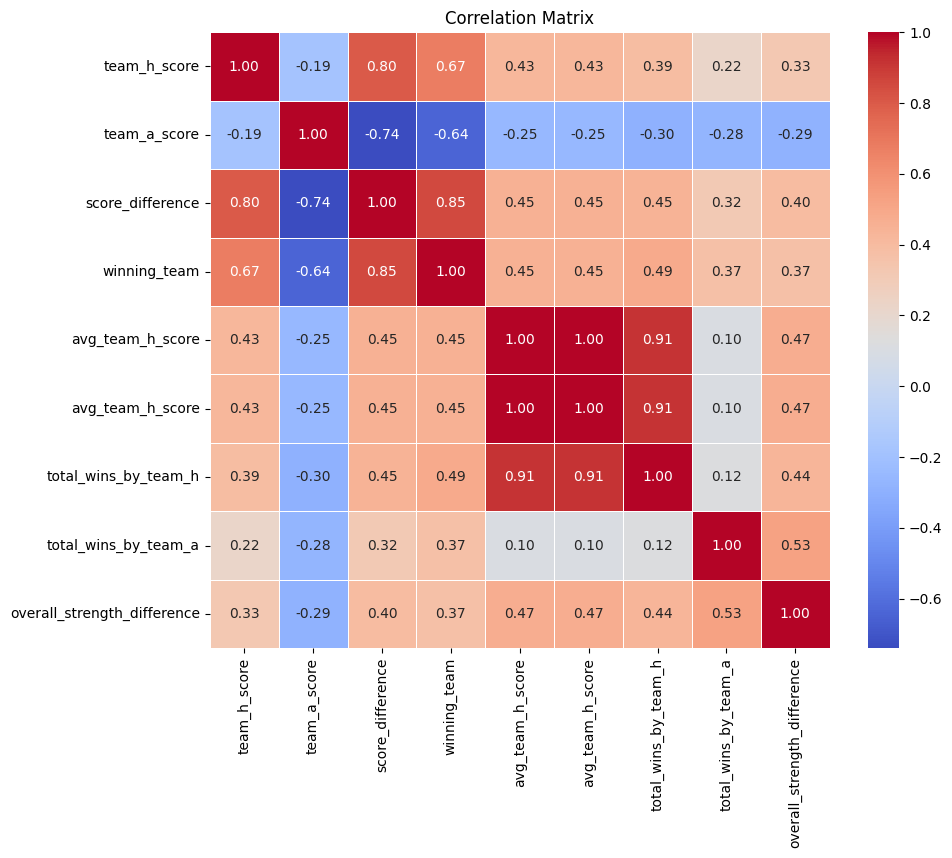

In [368]:
# Correlation analysis for home team data
correlation_matrix = finished_fixtures_with_teams_df[['team_h_score', 'team_a_score', 'score_difference', 'winning_team', 'avg_team_h_score','avg_team_h_score', 'total_wins_by_team_h',  'total_wins_by_team_a', 'overall_strength_difference']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

#### Training a model

In [378]:
# Extract features and target
X = finished_fixtures_with_teams_df[[ 'avg_team_h_score', 'std_team_h_score', 'total_wins_by_team_h', 'avg_team_a_score', 'std_team_a_score', 'total_wins_by_team_a', 'overall_strength_difference']]
y = finished_fixtures_with_teams_df['winning_team']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Model Evaluation

Lets explore the importance of each feature.

In [379]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': clf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
display(feature_importance)

,Feature,Importance
6,overall_strength_difference,0.200287
0,avg_team_h_score,0.167000
2,total_wins_by_team_h,0.138754
4,std_team_a_score,0.132583
5,total_wins_by_team_a,0.128299
1,std_team_h_score,0.126291
3,avg_team_a_score,0.106786


Lets look at the prediction probablities for each row of the training set.

In [382]:
# Predict probabilities for each class
probabilities = clf.predict_proba(features_for_prediction)

# The result is a numpy array where each row corresponds to a row in your DataFrame
# and each column corresponds to a class with its predicted probability
print(probabilities)

[[1.   0.   0.  ]
 [0.01 0.03 0.96]
 [0.18 0.75 0.07]
 [0.02 0.07 0.91]
 [0.78 0.11 0.11]
 [0.92 0.04 0.04]
 [0.02 0.   0.98]
 [0.11 0.77 0.12]
 [0.13 0.85 0.02]
 [0.57 0.03 0.4 ]
 [0.01 0.24 0.75]
 [0.71 0.   0.29]
 [0.   0.03 0.97]
 [0.66 0.11 0.23]
 [0.05 0.04 0.91]
 [0.01 0.03 0.96]
 [0.05 0.05 0.9 ]
 [0.03 0.18 0.79]
 [0.86 0.1  0.04]
 [0.06 0.01 0.93]
 [0.8  0.16 0.04]
 [0.   0.61 0.39]
 [0.12 0.7  0.18]
 [0.75 0.08 0.17]
 [0.11 0.04 0.85]
 [0.69 0.08 0.23]
 [0.9  0.07 0.03]
 [0.96 0.04 0.  ]
 [0.64 0.23 0.13]
 [0.82 0.13 0.05]
 [0.82 0.05 0.13]
 [0.2  0.71 0.09]
 [0.99 0.   0.01]
 [0.66 0.01 0.33]
 [0.   0.13 0.87]
 [0.04 0.02 0.94]
 [0.25 0.14 0.61]
 [0.03 0.08 0.89]
 [0.03 0.17 0.8 ]
 [0.79 0.13 0.08]
 [0.01 0.11 0.88]
 [0.18 0.   0.82]
 [0.74 0.09 0.17]
 [0.02 0.1  0.88]
 [0.76 0.18 0.06]
 [0.35 0.01 0.64]
 [0.11 0.77 0.12]
 [0.92 0.06 0.02]
 [0.04 0.83 0.13]
 [0.13 0.8  0.07]
 [0.26 0.62 0.12]
 [0.06 0.   0.94]
 [0.77 0.11 0.12]
 [0.92 0.05 0.03]
 [0.02 0.66 0.32]
 [0.25 0.0

Lets look at the overall accuracy of the model

In [400]:
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.36585365853658536


Lets look at a confusion matrix to help understand where the model is making errors

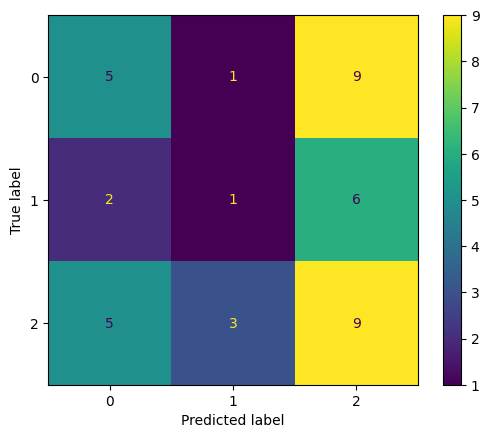

In [399]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='')
plt.show()

Lets look at the Precision, Recall, F1-Score

In [405]:
# Precision, Recall, F1-Score

y_pred = clf.predict(X_test)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.3659
Recall: 0.3659
F1-Score: 0.3659


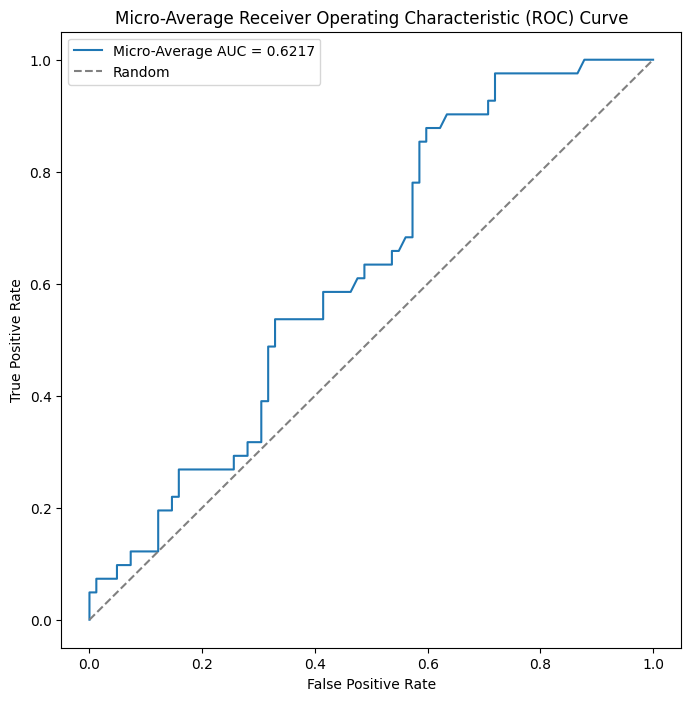

Micro-Average AUC: 0.6217


In [409]:
# ROC Curve and AUC
# Binarize the labels (convert multiclass labels to binary format)
y_test_binarized = label_binarize(y_test, classes=clf.classes_)

# Fit the classifier using the OneVsRestClassifier strategy
classifier = OneVsRestClassifier(clf)
y_scores = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(clf.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-Average AUC = {roc_auc["micro"]:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print(f'Micro-Average AUC: {roc_auc["micro"]:.4f}')

A value of 0.6217 for AUC indicates a classifier with moderate discriminative ability, performing better than random chance but potentially with room for improvement. Further analysis and consideration of other metrics are recommended for a comprehensive assessment of the classifier's performance.

In [412]:
# Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Adjust the number of splits as needed
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}')

Cross-Validation Accuracy Scores: [0.57575758 0.42424242 0.625      0.625      0.59375   ]
Mean Cross-Validation Accuracy: 0.5687


In [418]:
# Create and train the XGBoost Classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y)), random_state=42)
xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
roc_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test), multi_class='ovr')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Cross-validation
cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='accuracy')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}')

# Feature importance plot (if applicable)
xgb.plot_importance(xgb_clf)
plt.show()

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]